In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('stocks.csv', encoding = 'unicode_escape')

In [5]:
df.shape

(248, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     248 non-null    object 
 1   Date       248 non-null    object 
 2   Open       248 non-null    float64
 3   High       248 non-null    float64
 4   Low        248 non-null    float64
 5   Close      248 non-null    float64
 6   Adj Close  248 non-null    float64
 7   Volume     248 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.6+ KB


Data Preprocessing

In [7]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Sort data chronologically (very important for time series)
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

In [9]:
# Train polynomial regression model and forecast future prices
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def forecast_stock(ticker, degree=3, forecast_days=30):
    # Get stock data
    stock_data = df[df['Ticker'] == ticker].copy()
    stock_data = stock_data.sort_values('Date').reset_index(drop=True)

    # Convert dates to numerical (days since start)
    start_date = stock_data['Date'].min()
    stock_data['X'] = (stock_data['Date'] - start_date).dt.days

    # Prepare features and target
    X = stock_data['X'].values.reshape(-1, 1)
    y = stock_data['Close'].values

    # Train-test split (80-20, chronologically)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions on test set
    y_pred = model.predict(X_test_poly)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Forecast future prices
    last_day = X[-1][0]
    future_days = np.arange(last_day + 1, last_day + forecast_days + 1).reshape(-1, 1)
    future_poly = poly.transform(future_days)
    future_prices = model.predict(future_poly)

    # Create future dates
    future_dates = [stock_data['Date'].iloc[-1] + pd.Timedelta(days=i) for i in range(1, forecast_days + 1)]

    return {
        'ticker': ticker,
        'model': model,
        'poly': poly,
        'rmse': rmse,
        'r2': r2,
        'test_dates': stock_data['Date'].iloc[split_idx:],
        'test_actual': y_test,
        'test_predicted': y_pred,
        'future_dates': future_dates,
        'future_prices': future_prices,
        'all_dates': stock_data['Date'],
        'all_prices': stock_data['Close']
    }

print("Forecasting function defined successfully!")

Forecasting function defined successfully!


In [10]:
# Train models for all stocks
results = {}

for ticker in df['Ticker'].unique():
    results[ticker] = forecast_stock(ticker, degree=3, forecast_days=30)
    print(f"{ticker} - RMSE: ${results[ticker]['rmse']:.2f}, R²: {results[ticker]['r2']:.3f}")

print(f"\nAll {len(results)} Models trained successfully!")

AAPL - RMSE: $9.30, R²: -11.519
GOOG - RMSE: $13.23, R²: -115.078
MSFT - RMSE: $35.38, R²: -8.926
NFLX - RMSE: $18.06, R²: -24.294

All 4 Models trained successfully!


In [11]:
# Since the model performed poorly, we use more feature engineering
def create_enhanced_features(stock_data):
    """Create technical indicators and lag features"""
    stock_data = stock_data.copy()

    # 1. Price-based features
    stock_data['Price_Range'] = stock_data['High'] - stock_data['Low']
    stock_data['Price_Change'] = stock_data['Close'] - stock_data['Open']
    stock_data['Price_Change_Pct'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open'] * 100

    # 2. Moving averages
    stock_data['MA_3'] = stock_data['Close'].rolling(window=3, min_periods=1).mean()
    stock_data['MA_5'] = stock_data['Close'].rolling(window=5, min_periods=1).mean()
    stock_data['MA_10'] = stock_data['Close'].rolling(window=min(10, len(stock_data)), min_periods=1).mean()

    # 3. Lag features (previous day's prices)
    stock_data['Close_Lag1'] = stock_data['Close'].shift(1)
    stock_data['Close_Lag2'] = stock_data['Close'].shift(2)
    stock_data['Close_Lag3'] = stock_data['Close'].shift(3)

    # 4. Rolling statistics
    stock_data['Close_Rolling_Std'] = stock_data['Close'].rolling(window=5, min_periods=1).std()
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=3, min_periods=1).mean()

    # 5. Relative position features
    stock_data['Close_vs_MA5'] = stock_data['Close'] / stock_data['MA_5']
    stock_data['High_vs_Close'] = stock_data['High'] / stock_data['Close']
    stock_data['Low_vs_Close'] = stock_data['Low'] / stock_data['Close']

    # 6. Time-based features
    stock_data['Days_Since_Start'] = range(len(stock_data))

    # Fill missing values (from lag features)
    numeric_columns = stock_data.select_dtypes(include=[np.number]).columns
    stock_data[numeric_columns] = stock_data[numeric_columns].fillna(method='bfill').fillna(method='ffill')

    return stock_data

In [12]:
# Process all stocks
enhanced_data = {}
for ticker in df['Ticker'].unique():
    stock_data = df[df['Ticker'] == ticker].copy()
    stock_data = stock_data.sort_values('Date').reset_index(drop=True)

    enhanced_stock = create_enhanced_features(stock_data)
    enhanced_data[ticker] = enhanced_stock

    print(f"{ticker}: {len(enhanced_stock)} data points with {len(enhanced_stock.columns)} features")

AAPL: 62 data points with 23 features
GOOG: 62 data points with 23 features
MSFT: 62 data points with 23 features
NFLX: 62 data points with 23 features


/tmp/ipython-input-1437342118.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data[numeric_columns] = stock_data[numeric_columns].fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1437342118.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data[numeric_columns] = stock_data[numeric_columns].fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1437342118.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data[numeric_columns] = stock_data[numeric_columns].fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1437342118.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill()

In [13]:
from sklearn.preprocessing import StandardScaler

def enhanced_forecast_stock(ticker, degree=2, forecast_days=30):
    """
    Enhanced forecasting with technical indicators and multiple features
    """
    stock_data = enhanced_data[ticker].copy()

    # Select features for modeling (excluding target and non-numeric columns)
    feature_columns = [
        'Open', 'High', 'Low', 'Volume', 'Price_Range', 'Price_Change',
        'Price_Change_Pct', 'MA_3', 'MA_5', 'MA_10', 'Close_Lag1',
        'Close_Lag2', 'Close_Lag3', 'Close_Rolling_Std', 'Volume_MA',
        'Close_vs_MA5', 'High_vs_Close', 'Low_vs_Close', 'Days_Since_Start'
    ]

    # Prepare features and target
    X = stock_data[feature_columns].values
    y = stock_data['Close'].values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split (80-20, chronologically)
    split_idx = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Create polynomial features (lower degree to avoid overfitting)
    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=True)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions on test set
    y_pred = model.predict(X_test_poly)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # For forecasting, we need to simulate future features
    # Use the last known values and trends
    last_features = X_scaled[-1:].copy()
    future_predictions = []

    for day in range(forecast_days):
        # Create polynomial features for current prediction
        current_poly = poly.transform(last_features)
        next_price = model.predict(current_poly)[0]
        future_predictions.append(next_price)

        # Update features for next prediction (simple approach)
        # Update lag features with predicted price
        last_row = stock_data.iloc[-1].copy()

        # Update some key features (simplified approach)
        updated_features = last_features[0].copy()

        # Update Days_Since_Start
        days_idx = feature_columns.index('Days_Since_Start')
        updated_features[days_idx] = scaler.transform([[stock_data['Days_Since_Start'].iloc[-1] + day + 1] + [0]*(len(feature_columns)-1)])[0][days_idx]

        last_features = updated_features.reshape(1, -1)

    # Create future dates
    future_dates = [stock_data['Date'].iloc[-1] + pd.Timedelta(days=i) for i in range(1, forecast_days + 1)]

    return {
        'ticker': ticker,
        'model': model,
        'poly': poly,
        'scaler': scaler,
        'rmse': rmse,
        'r2': r2,
        'test_dates': stock_data['Date'].iloc[split_idx:],
        'test_actual': y_test,
        'test_predicted': y_pred,
        'future_dates': future_dates,
        'future_prices': future_predictions,
        'all_dates': stock_data['Date'],
        'all_prices': stock_data['Close'],
        'features_used': feature_columns
    }

print("Enhanced forecasting function ready!")

Enhanced forecasting function ready!


In [15]:
# Train enhanced models for all stocks
enhanced_results = {}
for ticker in df['Ticker'].unique():
    enhanced_results[ticker] = enhanced_forecast_stock(ticker, degree=2, forecast_days=30)
    rmse = enhanced_results[ticker]['rmse']
    r2 = enhanced_results[ticker]['r2']

    print(f"{ticker} - RMSE: ${rmse:.2f}, R²: {r2:.3f}")
    print(f"  Features used: {len(enhanced_results[ticker]['features_used'])}")

AAPL - RMSE: $1.86, R²: 0.498
  Features used: 19
GOOG - RMSE: $0.34, R²: 0.925
  Features used: 19
MSFT - RMSE: $2.28, R²: 0.959
  Features used: 19
NFLX - RMSE: $4.42, R²: -0.514
  Features used: 19


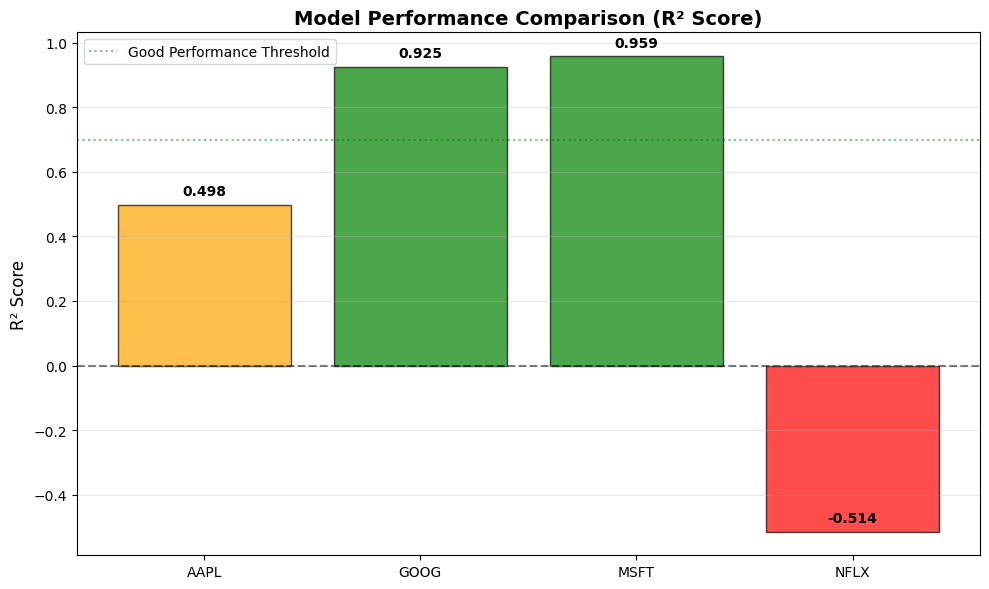

In [16]:
# Plot 1: Model Performance Comparison
plt.figure(figsize=(10, 6))

tickers = list(enhanced_results.keys())
r2_scores = [enhanced_results[ticker]['r2'] for ticker in tickers]

colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0 else 'red' for r2 in r2_scores]
bars = plt.bar(tickers, r2_scores, color=colors, alpha=0.7, edgecolor='black')

plt.title('Model Performance Comparison (R² Score)', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=0.7, color='green', linestyle=':', alpha=0.5, label='Good Performance Threshold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

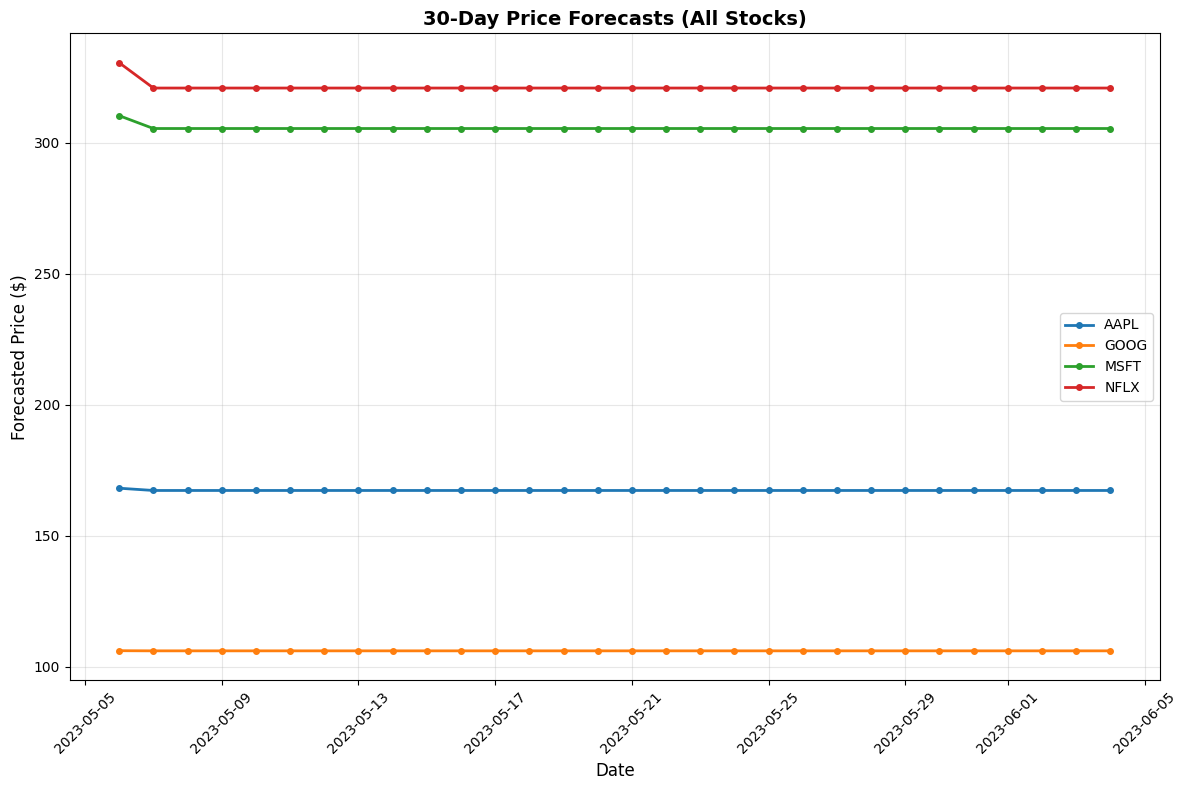

In [17]:
# Plot 2: All Future Forecasts
plt.figure(figsize=(12, 8))

for ticker in enhanced_results.keys():
    result = enhanced_results[ticker]
    plt.plot(result['future_dates'], result['future_prices'],
             marker='o', linewidth=2, label=f'{ticker}', markersize=4)

plt.title('30-Day Price Forecasts (All Stocks)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Price ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

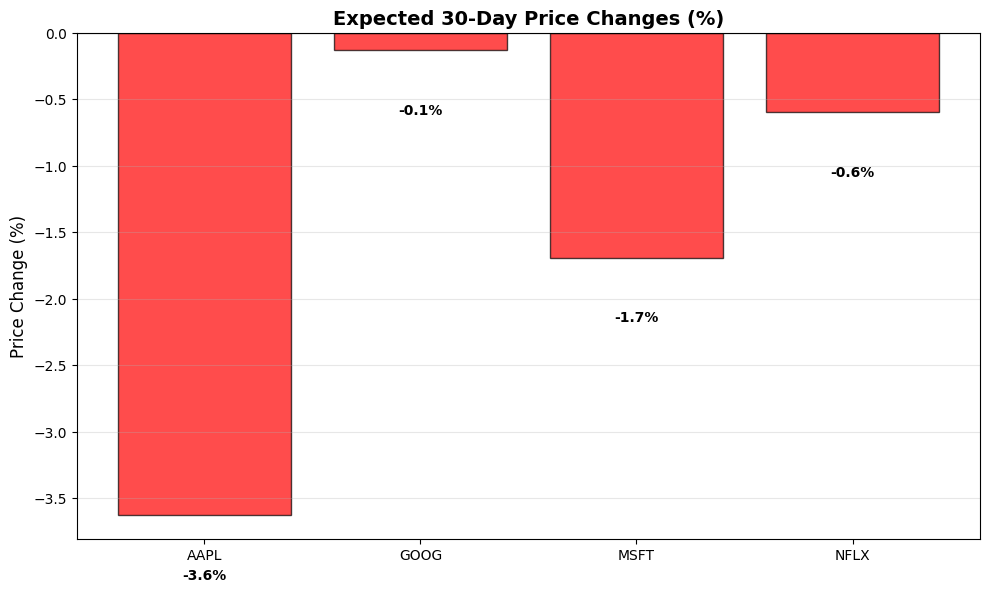

In [18]:
# Plot 3: Expected Price Changes
plt.figure(figsize=(10, 6))

tickers = list(enhanced_results.keys())
current_prices = [enhanced_results[ticker]['all_prices'].iloc[-1] for ticker in tickers]
future_prices = [enhanced_results[ticker]['future_prices'][-1] for ticker in tickers]
price_changes = [((future - current) / current) * 100
                for current, future in zip(current_prices, future_prices)]

colors = ['green' if change > 0 else 'red' for change in price_changes]
bars = plt.bar(tickers, price_changes, color=colors, alpha=0.7, edgecolor='black')

plt.title('Expected 30-Day Price Changes (%)', fontsize=14, fontweight='bold')
plt.ylabel('Price Change (%)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.8)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, change in zip(bars, price_changes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.2 if height >= 0 else -0.4),
             f'{change:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
             fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()